# Exercício 3
## 3ª Lista de Fundamentos em Redes Neurais e Aprendizagem Estatística
### by Lorran de Araújo Durães Soares

Imports:

In [1]:
from tensorflow.keras.datasets import cifar10
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.patches as mpatches
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import cv2

np.random.seed(42) # setando semente

2024-09-06 15:11:51.945656: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-06 15:11:52.135607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 15:11:52.247579: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 15:11:52.284116: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 15:11:52.519928: I tensorflow/core/platform/cpu_feature_guar

### Pré Processamento

Carregando conjunto de dados:

In [2]:
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

# concatena os dados
x_all = np.concatenate((data_train, data_test), axis=0)
y_all = np.concatenate((label_train, label_test), axis=0)

Filtrando para apenas carros e aviões:

In [3]:
categories = [0, 1]  # airplane, car
train_filter = np.isin(y_all, categories)

x_filt, y_filt = x_all[train_filter.flatten()], y_all[train_filter.flatten()]

Reduzindo conjunto de dados:

In [4]:
sample_size = 0.1
X_sample, _, y_sample, _ = train_test_split(x_filt, y_filt, test_size=1-sample_size, random_state=42, stratify=y_filt)
print(x_filt.shape)
print(X_sample.shape)

(12000, 32, 32, 3)
(1200, 32, 32, 3)


Plotando imagens do conjunto de dados:

In [5]:
def plot_images_grid(images, titles, rows=2, cols=4):

    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.flatten()  # achata o array de eixos para facilitar o acesso

    for img, title, ax in zip(images, titles, axes):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

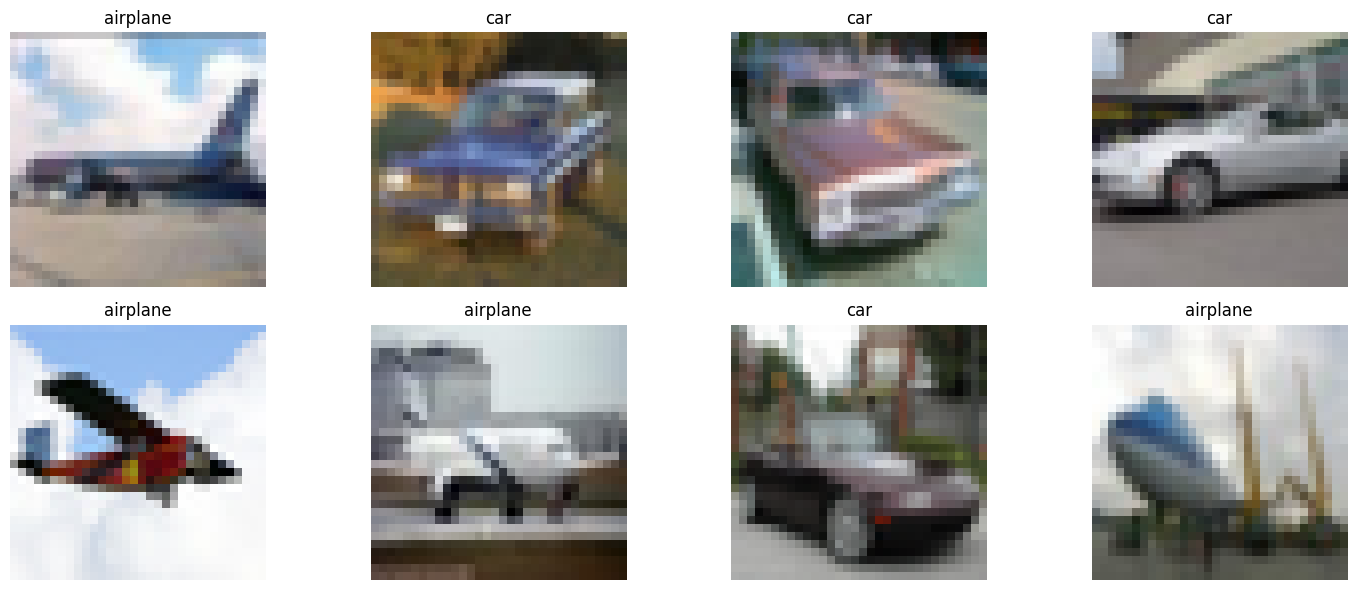

In [6]:
category_labels = {0: 'airplane', 1: 'car'}
num_imagem = 17
list_imgs = []
example_label = []

for i in range(8):
    list_imgs.append(X_sample[num_imagem*i])
    example_label.append(category_labels[y_sample[num_imagem*i][0]])

plot_images_grid(images=list_imgs, titles=example_label)

Convertendo para cinza:

In [7]:
def convert_to_gray(images):
    gray_images = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])
    return gray_images

In [8]:
x_all_gray = convert_to_gray(X_sample)

Vetorizando:

In [9]:
x_all_gray_flattened = x_all_gray.reshape(x_all_gray.shape[0], -1)

Conferindo formato:

In [10]:
print(f'Formato original das imagens: {x_filt.shape[1:]}')
print(f'Formato das imagens após conversão para cinza: {x_all_gray.shape[1:]}')
print(f'Formato das imagens vetorizadas: {x_all_gray_flattened.shape[1]}')

Formato original das imagens: (32, 32, 3)
Formato das imagens após conversão para cinza: (32, 32)
Formato das imagens vetorizadas: 1024


Escalando os dados:

In [11]:
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(x_all_gray_flattened)

Dividindo dados e embaralhando:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_sample_scaled, y_sample, test_size=0.3, random_state=42, shuffle=True, stratify=y_sample)

Olhando a distribuição do conjunto de testes:

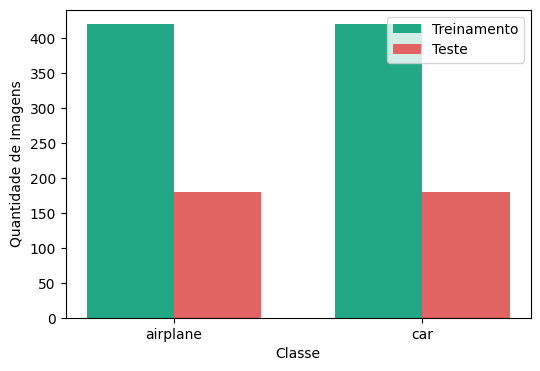

In [13]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
class_counts_train = dict(zip(unique_train, counts_train))

unique_test, counts_test = np.unique(y_test, return_counts=True)
class_counts_test = dict(zip(unique_test, counts_test))

class_names = ['airplane', 'car']

# Largura das barras
bar_width = 0.35

indices = np.arange(len(class_counts_train))

colors_train = plt.cm.viridis(0.6)  # Cor para o conjunto de treinamento
colors_test = plt.cm.plasma(0.6)  # Cor para o conjunto de teste

# Plotar o histograma do conjunto de treinamento
plt.figure(figsize=(6, 4))
plt.bar(indices, class_counts_train.values(), width=bar_width, label='Treinamento', color=colors_train)

# Plotar o histograma do conjunto de teste
plt.bar(indices + bar_width, class_counts_test.values(), width=bar_width, label='Teste', color=colors_test)

# Configurar o gráfico
plt.xlabel('Classe')
plt.ylabel('Quantidade de Imagens')
plt.xticks(indices + bar_width / 2, class_names, rotation=0)
plt.legend()

plt.show()

# Letra a):

Aplicando PCA no conjunto de treino:

In [14]:
pca = PCA()
pca.fit(X_train)

PCA()

Calculando e plotando variância explicada:

In [15]:
# Variância explicada cumulativa
variancia_explicada_cumulativa = np.cumsum(pca.explained_variance_ratio_)

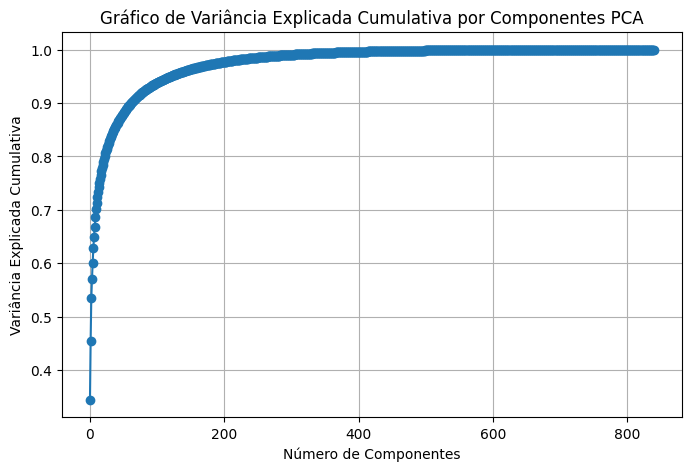

In [16]:
# Plotar o gráfico
plt.figure(figsize=(8, 5))
plt.plot(variancia_explicada_cumulativa, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Gráfico de Variância Explicada Cumulativa por Componentes PCA')
plt.grid()
plt.show()

Encontrando número de componentes que explicam pelo menos 95% da variância:

In [17]:
# Calcular a variância explicada cumulativa
variancia_explicada_cumulativa = np.cumsum(pca.explained_variance_ratio_)

# Encontrar o número de componentes que explicam pelo menos 95% da variância
n_componentes_95 = np.argmax(variancia_explicada_cumulativa >= 0.95) + 1

print(f'Número de componentes que explicam pelo menos 95% da variância: {n_componentes_95}')

Número de componentes que explicam pelo menos 95% da variância: 121


Reduzindo PCA para este número de componentes:

In [18]:
pca = PCA(n_components=n_componentes_95)
x_train_pca = pca.fit_transform(X_train)

Coloca o conjunto de treino na dimensão do pca:

In [19]:
X_test_pca = pca.transform(X_test)

Plotando PCA obtido:

In [20]:
def plot_kpca(x, y, title, class_labels):
    plt.figure(figsize=(8, 6))
    
    unique_classes = sorted(list(set(y.ravel())))  
    cmap = plt.get_cmap('cividis', len(unique_classes))  
    scatter = plt.scatter(x[:, 0], x[:, 1], c=y.ravel(), cmap=cmap, s=10)

    handles = [mpatches.Patch(color=cmap(i / (len(unique_classes)-1)), label=class_labels[i]) for i in range(len(unique_classes))]
    
    plt.legend(handles=handles, title="Classes")
    plt.title(title)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.show()

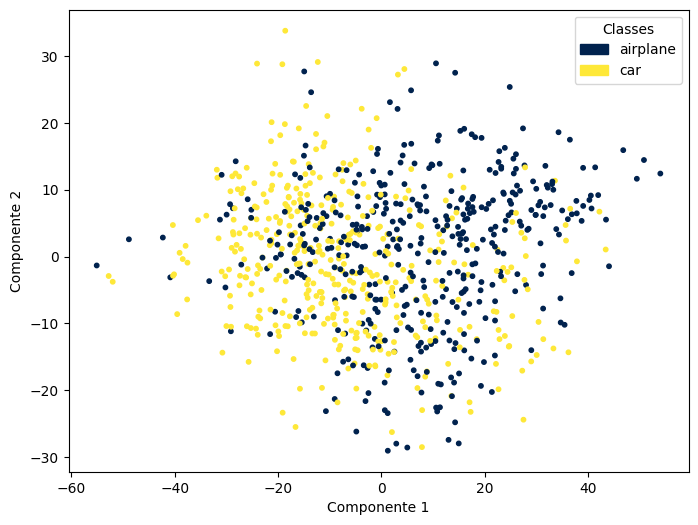

In [21]:
class_labels = ["airplane", "car"]

plot_kpca(x_train_pca, y_train, '', class_labels)

Treina o LDA:

In [24]:
kf1 = KFold(n_splits=4, shuffle=True, random_state=42)

# lista para armazenar os modelos
ldas = []

# itera sobre cada fold
for fold, (train_index, test_index) in enumerate(kf1.split(x_train_pca)):
    
    X_train2, X_val = x_train_pca[train_index], x_train_pca[test_index]
    y_train2, y_val = y_train[train_index], y_train[test_index]
    
    lda = LinearDiscriminantAnalysis(n_components=1)
    X_lda = lda.fit(X_train2, y_train2.ravel()).transform(X_train2)

    ldas.append(lda)
    
    # Avaliando o modelo
    y_pred1 = lda.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred1)
    print(f"Acurácia do LDA no conjunto de validação para o fold {fold+1}: {accuracy:.2f}")

    y_pred2 = lda.predict(X_test_pca)
    accuracy2 = accuracy_score(y_test, y_pred2)
    print(f"Acurácia do LDA no conjunto de testes para o fold {fold+1}: {accuracy2:.2f}")

    print("====================================================================================")

Acurácia do LDA no conjunto de validação para o fold 1: 0.82
Acurácia do LDA no conjunto de testes para o fold 1: 0.77
Acurácia do LDA no conjunto de validação para o fold 2: 0.75
Acurácia do LDA no conjunto de testes para o fold 2: 0.81
Acurácia do LDA no conjunto de validação para o fold 3: 0.72
Acurácia do LDA no conjunto de testes para o fold 3: 0.81
Acurácia do LDA no conjunto de validação para o fold 4: 0.77
Acurácia do LDA no conjunto de testes para o fold 4: 0.81


In [23]:
def plot_confusion(x_tests, y_tests, models, class_labels, i):
    
    rows = (i + 1) // 2  
    fig, axes = plt.subplots(rows, 2, figsize=(10, 5 * rows))  

    axes = np.atleast_2d(axes)

    for idx in range(i):
        y_pred = models[idx].predict(x_tests)

        cm = confusion_matrix(y_tests, y_pred)

        ax = axes[idx // 2, idx % 2]

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
        disp.plot(cmap='Blues', ax=ax)
        ax.set_title(f'Matriz de Confusão do K-fold = {idx+1}')

    if i % 2 != 0:
        fig.delaxes(axes[-1, -1])

    plt.tight_layout()
    plt.show()

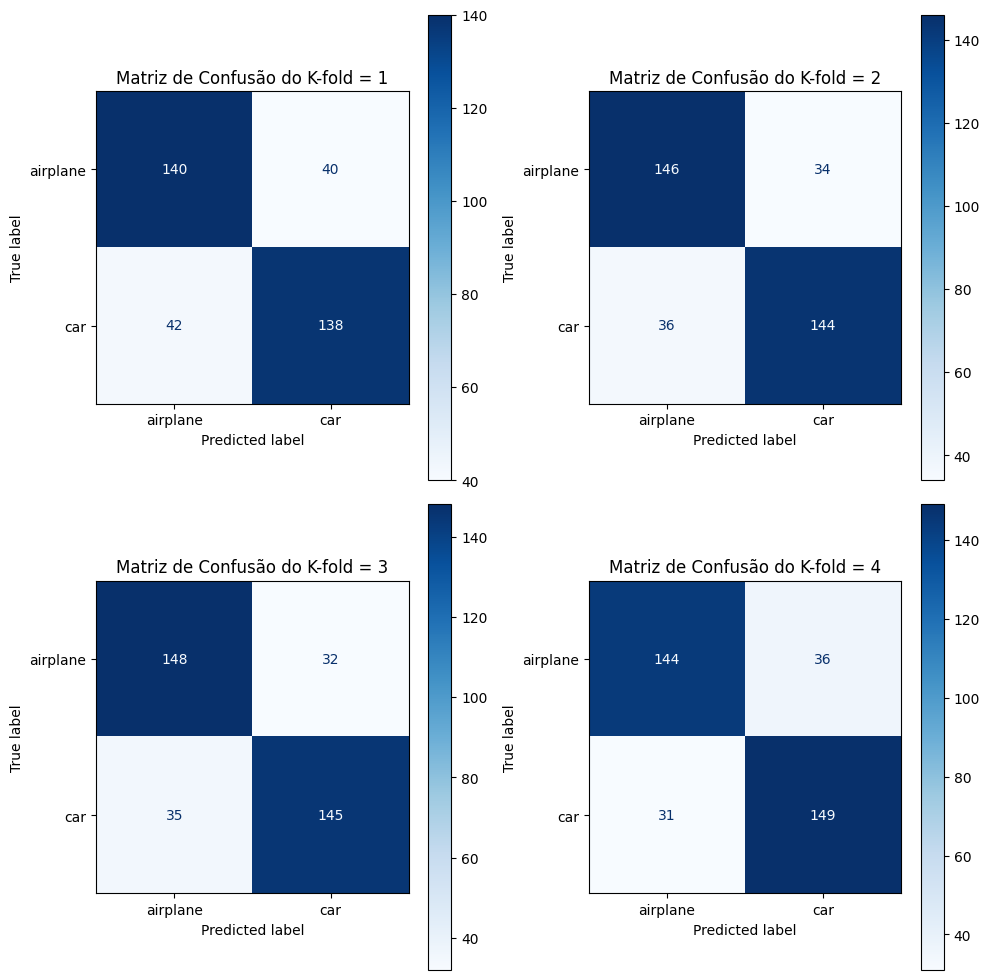

In [25]:
plot_confusion(x_tests=X_test_pca, y_tests=y_test, class_labels=['airplane', 'car'], models=ldas, i=4)

# Letra b):

Cálculo do PCA e da redução de dimensionalidade já foi feito anteriormente.

Aplicando SVM

In [26]:
clf_linear = SVC(kernel='linear')
clf_linear.fit(x_train_pca, y_train.ravel())

SVC(kernel='linear')

In [27]:
pesos = clf_linear.support_vectors_

In [28]:
pesos

array([[-1.03540144e+01,  1.17345886e+00,  1.03769547e+01, ...,
         5.16314930e-01, -1.74784373e-01,  2.47055601e-01],
       [-3.69202309e+00, -2.07858917e+00,  1.02648427e+01, ...,
        -3.33707002e-02,  4.67935123e-01,  1.95538100e-03],
       [-9.92052919e+00,  2.66193282e+00, -1.24715390e+00, ...,
         4.14536763e-01,  2.51868521e-03, -2.63246199e-01],
       ...,
       [-3.38714379e+01,  6.10870716e+00, -1.00710147e+01, ...,
         2.08655709e-01,  5.19688646e-01, -5.46416229e-01],
       [-2.31875868e+00, -1.63366435e+01,  1.34039173e+01, ...,
        -9.64717231e-01,  1.09274656e+00, -9.53741228e-01],
       [-1.14805255e+01, -1.96465493e+01, -9.97017582e+00, ...,
         2.98342641e-01, -5.93293007e-01,  8.77893653e-01]])

In [29]:
# Calcular o módulo (norma) de cada vetor
norms = np.linalg.norm(pesos, axis=0)

# Ordenar os índices dos vetores com base no módulo em ordem decrescente
sorted_indices = np.argsort(norms)[::-1]

pca_base = pca.components_

# Ordenar os vetores de suporte com base nos índices ordenados
pca_base_ordenado = pca_base[sorted_indices]

Projetando dados na nova base:

In [30]:
X_train_dpca = np.transpose(np.dot(pca_base_ordenado,np.transpose(X_train)))

In [31]:
X_teste_dpca = np.transpose(np.dot(pca_base_ordenado,np.transpose(X_test)))

Aplicando KSVM:

In [34]:
kf2 = KFold(n_splits=4, shuffle=True, random_state=42)

# lista para armazenar os modelos
svm_kernel = []

kernels = ['poly']

# itera sobre cada fold
for i, ker in enumerate(kernels):


    print(f"Utilizando o kernel {ker} no SVM:")

    print('====================================================')


    for train_index, test_index in kf2.split(X_train_dpca):
        
        X_train4, X_val = X_train_dpca[train_index], X_train_dpca[test_index]
        y_train4, y_val = y_train[train_index], y_train[test_index]
        
        # cria e treinar o modelo SVM
        clf_kernel = SVC(kernel=ker)
        clf_kernel.fit(X_train4, y_train4.ravel())

        svm_kernel.append(clf_kernel)
        

        print('====================================================')
        
        # avalia o modelo no conjunto de validação
        accuracy3 = clf_kernel.score(X_val, y_val)
        print(f"Acurácia da validaçao no fold {i+1}: {accuracy3:.2f}")
        
        # avalia o modelo no conjunto de teste
        accuracy4 = clf_kernel.score(X_teste_dpca, y_test)
        print(f"Acurácia do teste no fold {i+1}: {accuracy4:.2f}")
    

Utilizando o kernel poly no SVM:
Acurácia da validaçao no fold 1: 0.82
Acurácia do teste no fold 1: 0.84
Acurácia da validaçao no fold 1: 0.70
Acurácia do teste no fold 1: 0.83
Acurácia da validaçao no fold 1: 0.73
Acurácia do teste no fold 1: 0.77
Acurácia da validaçao no fold 1: 0.75
Acurácia do teste no fold 1: 0.82


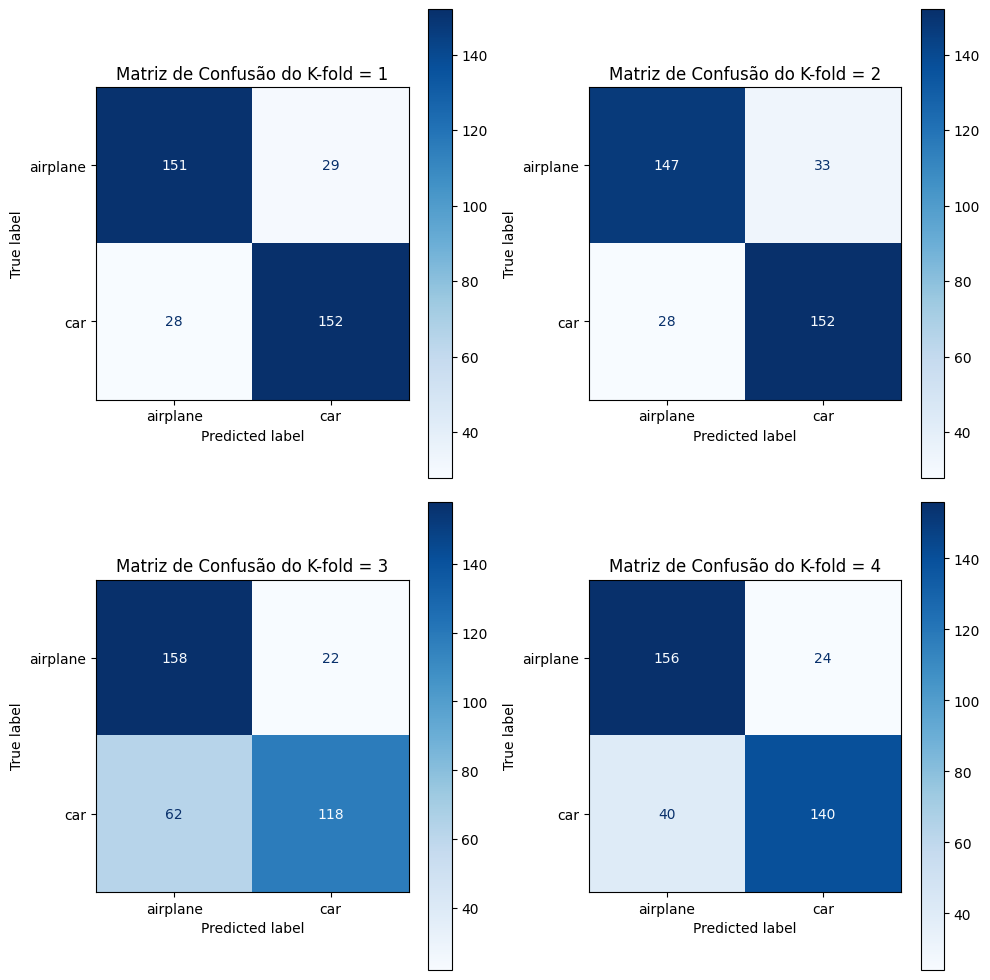

In [35]:
plot_confusion(x_tests=X_teste_dpca, y_tests=y_test, class_labels=['airplane', 'car'], models=svm_kernel, i=4)